# Train without normalization

This notebook will use the MotionSense resampled to 20Hz view (resampled_view_20Hz) and will:

1. Apply DFT over dataset windows
2. Train three times with RF, SVM and KNN, and take the average accuracy and f1-score
3. Plot UMAP and T-SNE

In [1]:
import sys
sys.path.append("../../..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from librep.datasets.har.loaders import MotionSense_BalancedView20HZ
from librep.datasets.multimodal import TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.transforms.filter import ButterWorthFilter
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport

2022-10-17 23:12:01.426476: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-17 23:12:01.426507: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Load MotionSense and create PandasMultiModalDatasets with the correct pre-defined windows
loader = MotionSense_BalancedView20HZ("../../../data/views/MotionSense/balanced_20Hz_with_gravity_9.81_acc", 
                                      download=False)
train_val, test = loader.load(concat_train_validation=True, 
                              label="standard activity code")
train_val, test

(PandasMultiModalDataset: samples=4020, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=1020, features=360, no. window=6, label_columns='standard activity code')

In [4]:
train_val.window_names, train_val.window_slices

(['accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z'],
 [(0, 60), (60, 120), (120, 180), (180, 240), (240, 300), (300, 360)])

In [5]:
# Checking the whole data...
train_val[:][0]

array([[ 2.72870487,  1.7450335 ,  1.74760785, ...,  0.29260805,
         0.932535  ,  0.78214699],
       [-2.33740561,  0.4921356 , -1.90527635, ...,  0.71842028,
         0.33650671,  0.93656304],
       [ 2.37405476,  1.48668374,  2.12881259, ...,  0.66747733,
        -0.0253858 , -0.03709332],
       ...,
       [ 9.08892167,  6.32077202,  3.28219902, ..., -1.27783961,
        -2.12259886, -1.6891165 ],
       [ 1.03940009, -1.89711408, -3.18845181, ...,  1.43220992,
         0.48111957, -2.24206567],
       [ 5.72999537, -0.03589438,  5.32189443, ..., -2.31604419,
        -1.94461612,  0.71415276]])

In [6]:
# 1. Perform standard scaler in train dataset
#train_scaler = StandardScaler()
#train_scaler.fit(train_val[:][0])
# OK Standard scaler was fit over train dataset.

Let's create the transforms. In general (by default) transforms are applyied over each window of the dataset, separadetly. We can control how transform will be applyied using Wrapping the transform arround `WindowedTransform`. 

The `WindowedTransform` receives, as argument to the constructor:

- The transform to be wrapped
- `fit_on`: can be "all" (apply fit over the whole dataset), "window" (apply fit over each window) or None (does not do fit).
- `transform_on`: can be "all" (apply transform over the whole dataset) or "window" (apply transform over each window)


One transformers will be created:

- `fft_transform`: Apply the transforms over windows of the dataset

In [7]:
filter_transform = ButterWorthFilter(btype='low')
# Compose the transform

windowed_fft_transform = WindowedTransform(
    filter_transform, fit_on="all", transform_on="window", select_windows=['accel-x', 
                                                                           'accel-y', 
                                                                           'accel-z'],
    keep_remaining_windows=False
)

transformer = TransformMultiModalDataset(transforms=windowed_fft_transform)

In [8]:
# Transform it and generate a new dataset!
train_gravity = transformer(train_val)
test_gravity = transformer(test)
train_gravity.window_names, test_gravity.window_names

(['accel-x', 'accel-y', 'accel-z'], ['accel-x', 'accel-y', 'accel-z'])

In [9]:
# Checking the whole data...
train_gravity[:][0]

array([[ 2.60434437e-04,  1.68008430e-03,  5.48375846e-03, ...,
         3.24729692e+00,  3.26927254e+00,  3.29025812e+00],
       [-2.23087855e-04, -1.24952085e-03, -3.63425608e-03, ...,
        -1.92709091e+00, -1.89133528e+00, -1.84903544e+00],
       [ 2.26585741e-04,  1.45871256e-03,  4.81159683e-03, ...,
        -1.64973465e+00, -1.63095825e+00, -1.61025472e+00],
       ...,
       [ 8.67469483e-04,  5.64463315e-03,  1.83052439e-02, ...,
         3.07915600e-01,  3.12986862e-01,  3.18072043e-01],
       [ 9.92029516e-05,  3.95459935e-04,  3.00020023e-04, ...,
         3.00882485e-02, -1.06564649e-02, -4.96692256e-02],
       [ 5.46885131e-04,  3.17483738e-03,  9.62056085e-03, ...,
         2.26164108e-01,  2.30517110e-01,  2.34143465e-01]])

In [10]:
train_val.data.iloc[:,:180]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,accel-z-50,accel-z-51,accel-z-52,accel-z-53,accel-z-54,accel-z-55,accel-z-56,accel-z-57,accel-z-58,accel-z-59
0,2.728705,1.745033,1.747608,1.638583,2.269632,2.113769,0.898506,4.521329,-0.366598,2.253692,...,1.983471,5.114435,2.491741,2.531192,0.494120,6.079352,4.330944,7.710874,3.557352,0.699212
1,-2.337406,0.492136,-1.905276,-0.792931,-3.633312,-2.010541,-1.999180,0.775418,5.222073,0.376617,...,4.164672,-4.476509,-13.525198,-11.650439,10.716209,4.586596,0.677327,3.239789,-3.122539,1.615982
2,2.374055,1.486684,2.128813,2.122220,2.159086,0.324434,1.700915,0.386075,2.253103,0.717394,...,-6.338226,-4.922207,-2.466949,-0.870332,1.462362,0.243822,-1.795911,0.290639,1.486660,-1.419893
3,-0.008749,-1.415145,4.735210,6.788520,3.669158,-0.650310,3.426964,2.332666,-4.960264,7.540761,...,-3.379523,-1.838204,-3.979857,0.284931,-5.231776,0.472394,3.017750,-3.903771,-4.102753,-4.005350
4,-1.186589,2.843267,-1.713601,1.908354,-0.582225,0.877230,-1.084176,-2.460460,-2.749313,-2.764776,...,-1.194937,-1.363381,-0.114927,-2.147671,-3.360676,0.854088,-0.621628,-3.630101,-2.005332,-5.449966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,0.438115,3.255994,-1.157529,5.054688,1.628169,3.667514,6.295931,-11.171494,-3.078356,2.127215,...,-1.957632,-0.330376,2.468769,1.177613,6.507658,11.088560,7.586083,-15.984070,-5.365193,5.917774
4016,-5.743063,-1.773532,17.991325,2.019050,-12.776854,0.271147,14.655750,-7.677687,7.842073,3.805292,...,2.584252,-4.058414,-0.602657,-3.205355,-3.376255,4.011174,-0.594062,-5.010832,3.063026,3.300419
4017,9.088922,6.320772,3.282199,-1.925583,2.372136,0.010677,0.871883,-8.905142,8.317873,2.808271,...,0.331221,-5.822868,-2.429681,2.451886,2.223324,-3.860732,4.290491,1.211136,0.073497,-0.907241
4018,1.039400,-1.897114,-3.188452,-4.827097,4.312984,1.968542,-2.217618,-0.245953,1.426658,0.841435,...,0.762644,-1.475022,1.090963,1.859446,1.918071,-2.222394,-3.642264,-3.312129,4.494877,0.384371


In [11]:
train_val.data.iloc[:,:180] -= train_gravity[:][0]
train_val.data.iloc[:,:180]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,accel-z-50,accel-z-51,accel-z-52,accel-z-53,accel-z-54,accel-z-55,accel-z-56,accel-z-57,accel-z-58,accel-z-59
0,2.728444,1.743353,1.742124,1.625969,2.245902,2.074328,0.838332,4.435124,-0.484462,2.098607,...,-0.962331,2.104078,-0.575326,-0.585456,-2.665017,2.885001,1.107860,4.463577,0.288079,-2.591047
1,-2.337183,0.493385,-1.901642,-0.785124,-3.618851,-1.985848,-1.959588,0.834929,5.305343,0.484825,...,6.276044,-2.387121,-11.465178,-9.621142,12.719210,6.566976,2.633637,5.166880,-1.231204,3.465017
2,2.373828,1.485225,2.124001,2.110892,2.137167,0.287275,1.643859,0.304800,2.143632,0.575976,...,-4.532123,-3.146733,-0.719503,0.853153,3.165604,1.928961,-0.128338,1.940373,3.117618,0.190362
3,-0.008748,-1.415005,4.735557,6.787529,3.662057,-0.670756,3.385570,2.263021,-5.064820,7.396114,...,-1.613270,-0.104827,-2.278521,1.956086,-3.588328,2.091120,4.614426,-2.327929,-2.547012,-2.467585
4,-1.186476,2.843653,-1.713123,1.908377,-0.583373,0.874038,-1.090264,-2.469749,-2.760805,-2.775741,...,-0.053069,-0.163805,1.142347,-0.833840,-1.992027,2.275705,0.850488,-2.110855,-0.442323,-3.845674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,0.438073,3.255440,-1.159923,5.048260,1.614376,3.641573,6.251493,-11.241305,-3.177437,1.999448,...,-2.138566,-0.531826,2.257696,0.965715,6.300761,10.888074,7.387351,-16.189221,-5.581416,5.691789
4016,-5.742514,-1.770177,17.999745,2.030031,-12.769776,0.270363,14.645940,-7.699661,7.802777,3.742894,...,3.741559,-2.871066,0.610487,-1.969870,-2.120788,5.284956,0.695571,-3.708801,4.374336,4.617575
4017,9.088054,6.315127,3.263894,-1.966297,2.300108,-0.099931,0.716789,-9.108421,8.065769,2.507593,...,0.106108,-6.065684,-2.689878,2.177149,1.937175,-4.156043,3.988079,0.903221,-0.239490,-1.225313
4018,1.039301,-1.897510,-3.188752,-4.825161,4.320957,1.985861,-2.189499,-0.206340,1.478511,0.905703,...,0.352089,-1.819676,0.809285,1.637402,1.751232,-2.339414,-3.714368,-3.342217,4.505533,0.434040


In [12]:
test.data.iloc[:,:180] -= test_gravity[:][0]

In [13]:
# Create the objects
#scaler_transform = WindowedTransform(
#    transform=train_scaler, fit_on=None, transform_on="all")
fft_transform = FFT()
# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[fft_transform], new_window_name_prefix="fft."
)

In [14]:
# Transform it and generate a new dataset!
train_val_fft_filtered = transformer(train_val)
test_fft_filtered = transformer(test)

In [15]:
# Checking the whole data...
train_val_fft_filtered[:][0]

array([[39.39666833, 36.4917524 , 18.59032699, ...,  7.47277363,
         3.77121234,  9.62952042],
       [28.18843226, 21.75247206,  6.10066211, ...,  0.83487658,
         0.4655761 ,  2.86996899],
       [14.50996658,  6.68872686, 53.63268805, ...,  3.07408871,
        14.93903516,  1.93762252],
       ...,
       [20.47046237, 22.33821694, 16.5513359 , ...,  6.37142947,
         6.59713927,  4.46684396],
       [35.8751904 , 49.68034784,  0.2767692 , ..., 20.33465754,
         6.77587918,  5.01996318],
       [23.17753209, 27.2213491 ,  3.03361063, ...,  4.33612894,
         0.26990502,  1.34881454]])

## Classification

Let's take the transformed datasets and train using RandomForest, SVM and KNN 3 times each. Then take the average accuracy and f1-score over the runs

In [16]:
# The reporter will be the same

reporter = ClassificationReport(
    use_accuracy=True,
    use_f1_score=True,
    use_classification_report=True,
    use_confusion_matrix=True,
    plot_confusion_matrix=True,
    # normalize='true'
)

### RandomForest

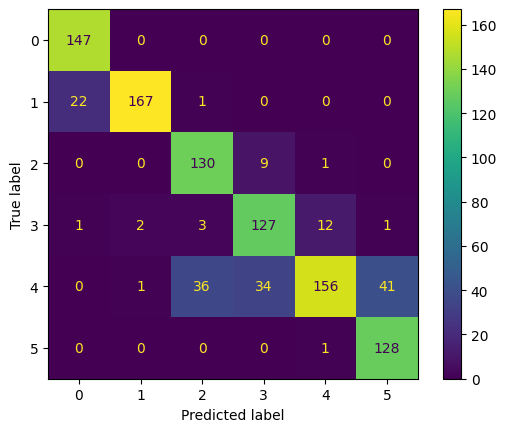

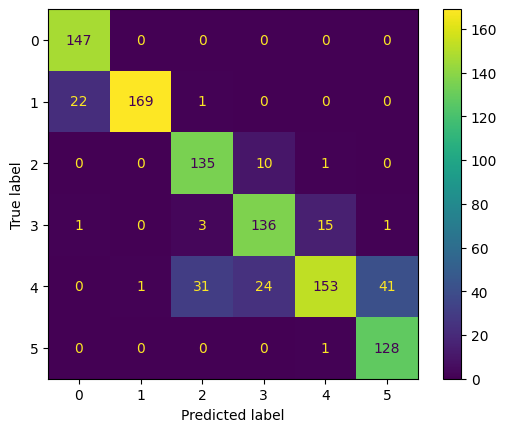

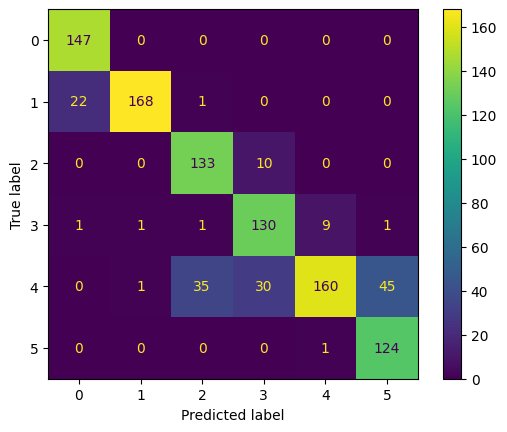

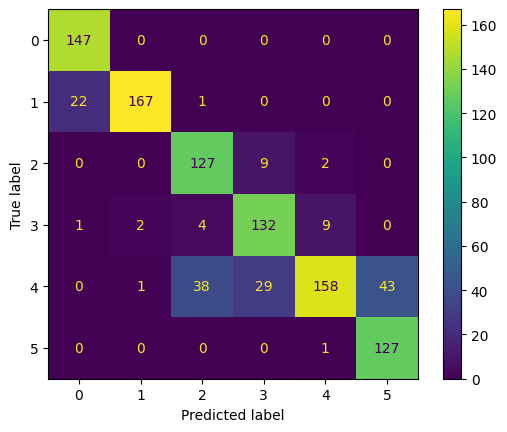

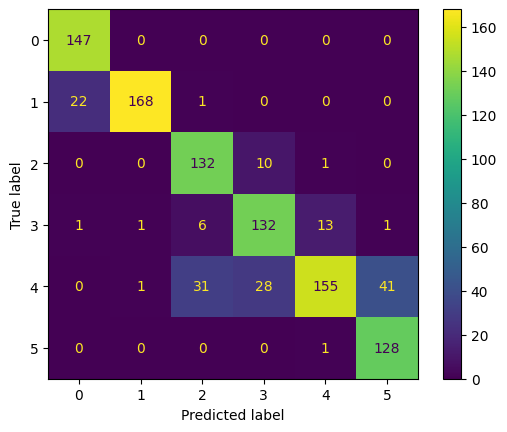

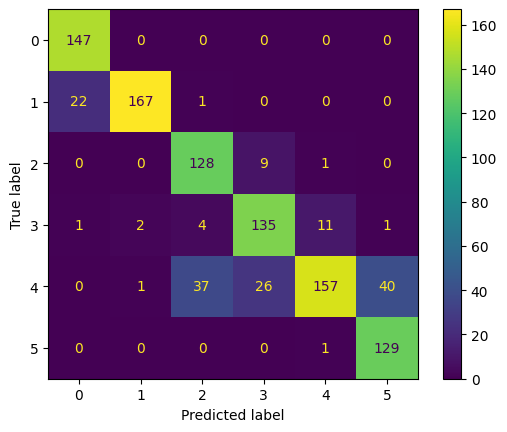

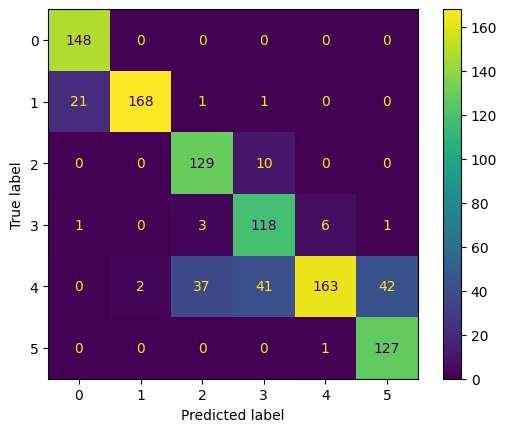

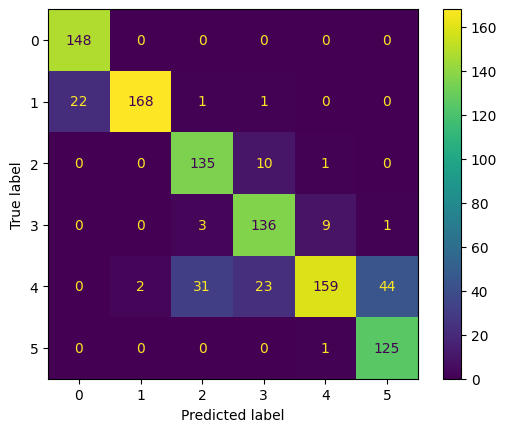

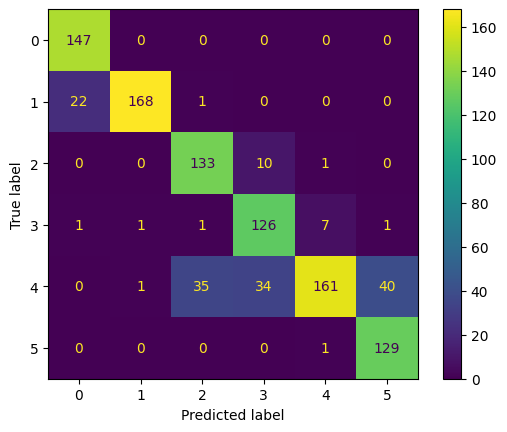

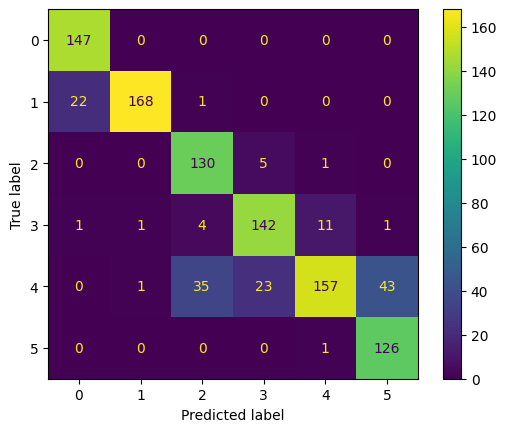

Mean accuracy (10 runs): 0.8457. Mean f1-score: 0.8402
Standard deviation accuracy (10 runs): 0.0056. Standard deviation f1-score: 0.0061


In [17]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)
results = multi_run_experiment(train_val_fft_filtered, [test_fft_filtered])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (10 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

### SVM

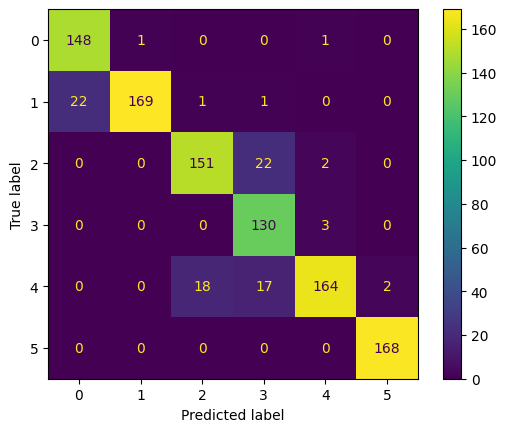

Mean accuracy (1 runs): 0.9118. Mean f1-score: 0.9122
Standard deviation accuracy (1 runs): 0.0000. Standard deviation f1-score: 0.0000


In [18]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
results = multi_run_experiment(train_val_fft_filtered, [test_fft_filtered])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (1 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (1 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

### KNN

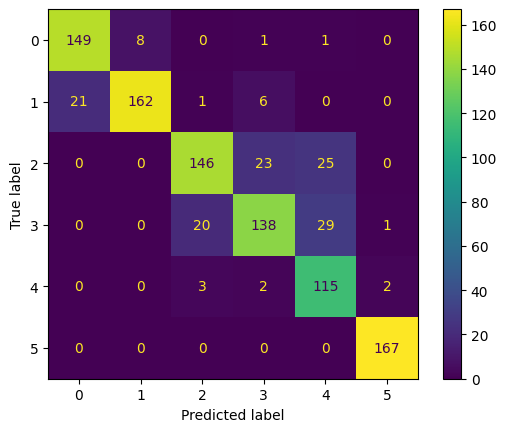

Mean accuracy (1 run): 0.8598. Mean f1-score: 0.8600
Standard deviation accuracy (1 run): 0.0000. Standard deviation f1-score: 0.0000


In [19]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
results = multi_run_experiment(train_val_fft_filtered, [test_fft_filtered])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (1 run): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (1 run): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

## Plot UMAP and T-SNE

In [20]:
def plot(df, figsize: tuple = (5, 5), title: str = None, labels: dict = None):
    fig, ax = plt.subplots(figsize=figsize)
    for label, group_df in df.groupby("label"):
        label = labels[label] if labels is not None else label
        ax.scatter(group_df.x, group_df.y, label=label)
    ax.legend()
    plt.title(title)
    plt.show()

In [21]:
standard_activity_codes = {
    0: "sit",
    1: "stand",
    2: "walk",
    3: "stair up",
    4: "stair down",
    5: "run",
    6: "stair up and down"
}
print(standard_activity_codes)

{0: 'sit', 1: 'stand', 2: 'walk', 3: 'stair up', 4: 'stair down', 5: 'run', 6: 'stair up and down'}


### UMAP

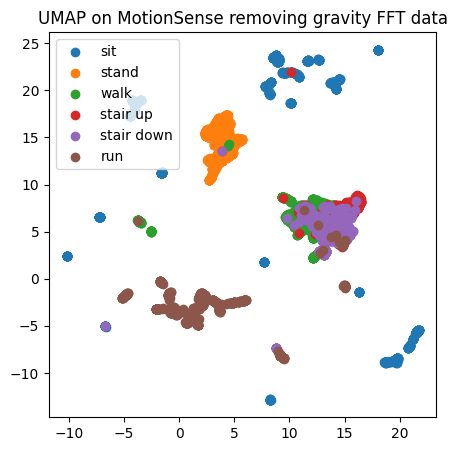

In [22]:
model = UMAP(n_components=2, random_state=0)
result = pd.DataFrame(model.fit_transform(train_val_fft_filtered[:][0]), columns=["x", "y"])
result["label"] = train_val_fft_filtered[:][1]
plot(result, title="UMAP on MotionSense removing gravity FFT data", labels=standard_activity_codes)

### T-SNE

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


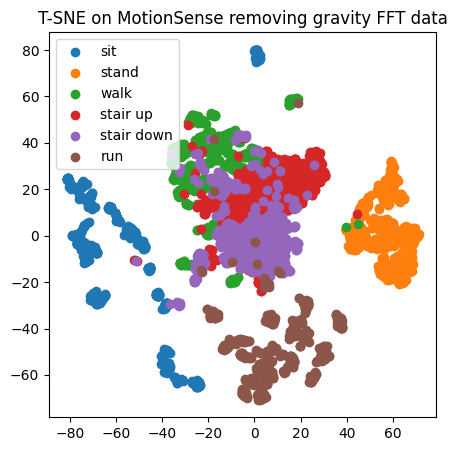

In [23]:
model = TSNE(n_components=2, random_state=0)
result = pd.DataFrame(model.fit_transform(train_val_fft_filtered[:][0]), columns=["x", "y"])
result["label"] = train_val_fft_filtered[:][1]
plot(result, title="T-SNE on MotionSense removing gravity FFT data", labels=standard_activity_codes)